# Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import ttest_ind, levene, shapiro, probplot

In [2]:
#читаем датасет
data = pd.read_csv('C:/Users/glebv/Desktop/Олимпиады/DANO/sm_verySmall_random.csv')

In [3]:
#стиль для matplotlib
plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
# import webbrowser as web
# web.open_new('https://dano.hse.ru/mirror/pubs/share/987927730.pdf')

In [5]:
#убираю время
data['create_timestamp'] = data['create_timestamp'].str.split('T').str[0]
data = data.sort_values('create_timestamp')
data = data.reset_index(drop=True)

In [6]:
#перевод в формат даты
data['create_timestamp'] = pd.to_datetime(data['create_timestamp']).dt.date

In [7]:
#перевод дня в формат даты
data['day'] = pd.to_datetime(data['create_timestamp']).dt.day

In [8]:
#переименование
data['device_type'] = data['device_type'].replace({
    'mobileapp_android': 'android',
    'mobileapp_ios': 'ios'})

In [9]:
#удаление лишнего
data = data.drop(columns=['event_id', 'location_id'])

In [10]:
#перемещаю столбец в конец
cd = data.pop('product_id')
data['product_id'] = cd

# Анализ

In [11]:
st = data.shape[0]
print(f'Количество строк: {st}')
un = data['user_id'].nunique()
print(f'Количесво пользователей: {un}')
print(f'Промежуток данных: c {data.iloc[0, 3]} до {data.iloc[-1, 3]}')
dd = (data['create_timestamp'].iloc[-1] - data['create_timestamp'].iloc[0]).days
print('Количество дней:', dd + 1)
up = data['product_id'].nunique()
print('Количесво товаров:', up)

Количество строк: 99617
Количесво пользователей: 30000
Промежуток данных: c 2024-06-01 до 2024-06-21
Количество дней: 21
Количесво товаров: 21697


In [12]:
#удалил аномальные в данных как выбросы
data = data[~((data['user_is_authorized'] == 0) & (data['create_order_flag'] == 1))].reset_index(drop=True)

In [13]:
datal = []
names = ['desktop', 'android', 'ios']

for n in names:
    dataf = data[data['create_order_flag'] == 1]
    dataf = dataf[dataf['device_type'] == n]
    datas = dataf['product_price'].mean()
    datam = dataf['product_price'].median()
    datal.append({
        'device': n,
        'средняя цена': round(datas, 2),
        'медианная цена': datam})
df = pd.DataFrame(datal)
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+----------+----------------+------------------+
| device   |   средняя цена |   медианная цена |
|----------+----------------+------------------|
| desktop  |        4820.03 |             3039 |
| android  |        3620.89 |             2199 |
| ios      |        4173.92 |             2599 |
+----------+----------------+------------------+


In [14]:
datal = []
names = ['обувь', 'одежда', 'инвентарь']

for n in names:
    dataf = data[data['product_category'] == n]
    datas = dataf['product_price'].mean()
    datam = dataf['product_price'].median()
    datao = dataf[dataf['create_order_flag'] == 1].shape[0]
    datac = dataf[dataf['add_to_cart_flag'] == 1].shape[0]
    datal.append({
        'продукт': n,
        'конверсия': round(datao / datac * 100, 2),
        'средняя цена': round(datas, 2),
        'медианная цена': datam,
        'количество покупок': datao
    })

df = pd.DataFrame(datal)
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+-----------+-------------+----------------+------------------+----------------------+
| продукт   |   конверсия |   средняя цена |   медианная цена |   количество покупок |
|-----------+-------------+----------------+------------------+----------------------|
| обувь     |       26.46 |        5770.14 |             4599 |                 1752 |
| одежда    |       26.97 |        2807.02 |             1899 |                 2572 |
| инвентарь |       27.17 |       11490.4  |             4479 |                  703 |
+-----------+-------------+----------------+------------------+----------------------+


In [15]:
# товары НЕДОСТУПНЫЕ для самовывоза из пункта самовывоза имею более высокую средню цену
datal = []
ans = []
names = ['pick_up', 'pick_point', 'delivery', 'now']

for i in range(4):
    for n in range(2):
        dataf = data[data.iloc[:, i + 4] == n] 
        datam = dataf['product_price'].mean()
        datac = dataf.shape[0]
        ans.extend([datam, datac])
    datal.append({
        'name': names[i],
        'ср 0': ans[0],
        'ср 1': ans[2],
        'кол 0': ans[1],
        'кол 1': ans[3]
    })
    ans.clear()
df = pd.DataFrame(datal)
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+------------+----------+---------+---------+---------+
| name       |     ср 0 |    ср 1 |   кол 0 |   кол 1 |
|------------+----------+---------+---------+---------|
| pick_up    |  7712.57 | 4175.7  |   27449 |   72124 |
| pick_point | 10573.5  | 4684.28 |    7886 |   91687 |
| delivery   |  7629.02 | 4953.27 |    7347 |   92226 |
| now        |  6024.04 | 3999    |   56630 |   42943 |
+------------+----------+---------+---------+---------+


In [16]:
datal = []
ans = []
names = ['desktop', 'android', 'ios']

dataf = data[data['create_order_flag'] == 1]
for i in names:
    dataff = dataf[dataf['device_type'] == i]
    for n in range(4):
        datafc = (dataff[dataff.iloc[:, n + 4] == 1]).shape[0]
        ans.append(datafc)
    datal.append({
        'device': i,
        'pick_up': ans[0],
        'pick_point': ans[1],
        'delivery': ans[2],
        'now': ans[3]})
    ans.clear()

df = pd.DataFrame(datal)
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+----------+-----------+--------------+------------+-------+
| device   |   pick_up |   pick_point |   delivery |   now |
|----------+-----------+--------------+------------+-------|
| desktop  |       241 |          283 |        289 |    53 |
| android  |      2510 |         2810 |       2837 |  2510 |
| ios      |      1541 |         1735 |       1777 |     0 |
+----------+-----------+--------------+------------+-------+


In [17]:
# Проверки на устойчивость. Можно взять product_gender женщины и унисекс
# Средняя цена
datal = []
ans = []
names = ['desktop', 'android', 'ios']
tipes = ['взрослые', 'дети', 'малыши']

dataf = data[data['create_order_flag'] == 1]
for i in names:
    dataff = dataf[dataf['device_type'] == i]
    for n in tipes:
        dataft = dataff[dataff['product_age'] == n]
        datafc = dataft['product_price'].mean()
        ans.append(datafc)
    datal.append({
        'device': i,
        'взрослые': ans[0],
        'дети': ans[1],
        'малыши': ans[2]
    })
    ans.clear()

df = pd.DataFrame(datal)
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+----------+------------+---------+----------+
| device   |   взрослые |    дети |   малыши |
|----------+------------+---------+----------|
| desktop  |    4900.65 | 4039.75 |      nan |
| android  |    3818.67 | 2455.11 |     1054 |
| ios      |    4484.84 | 2522.06 |      999 |
+----------+------------+---------+----------+


In [18]:
dataf = data[(data['create_order_flag'] == 1) & (data['device_type'] == 'desktop') & (data['product_age'] == 'малыши')]
print(dataf.shape[0])

0


In [19]:
datal = []
names = ['взрослые', 'дети', 'малыши']

for n in range(3):
    dataf = data[data['product_age'] == names[n]]
    mean = dataf['product_price'].mean()
    med = dataf['product_price'].median()
    kol = dataf[dataf['create_order_flag'] == 1].shape[0]
    datal.append({
        'Возраст': names[n],
        'Средняя цена': mean,
        'Мединанная цена': med,
        'Количество покупок': kol
    })

df = pd.DataFrame(datal)
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+-----------+----------------+-------------------+----------------------+
| Возраст   |   Средняя цена |   Мединанная цена |   Количество покупок |
|-----------+----------------+-------------------+----------------------|
| взрослые  |        5367.59 |              3249 |                 4297 |
| дети      |        3467.06 |              2249 |                  721 |
| малыши    |        2499.58 |              1999 |                    9 |
+-----------+----------------+-------------------+----------------------+


In [20]:
datal = []
names = ['женский', 'унисекс', 'мужской']
for n in names:
    dataf = data[data['product_gender'] == n]
    mean = dataf['product_price'].mean()
    med = dataf['product_price'].median()
    kol = dataf[dataf['create_order_flag'] == 1].shape[0]
    datal.append({
        'Пол товара': n,
        'Средняя цена': mean,
        'Медианная цена': med,
        'Количество покупок': kol
    })

df = pd.DataFrame(datal)
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+--------------+----------------+------------------+----------------------+
| Пол товара   |   Средняя цена |   Медианная цена |   Количество покупок |
|--------------+----------------+------------------+----------------------|
| женский      |        4199.46 |             2999 |                 1423 |
| унисекс      |        6090.76 |             2499 |                 1027 |
| мужской      |        5436    |             3399 |                 2577 |
+--------------+----------------+------------------+----------------------+


# Графики

In [21]:
color = '#FF1493'
colors = ['#FF69B4', '#FF1493', '#C71585']
colors1 = ['#FFA07A', '#FA8072', '#F08080']

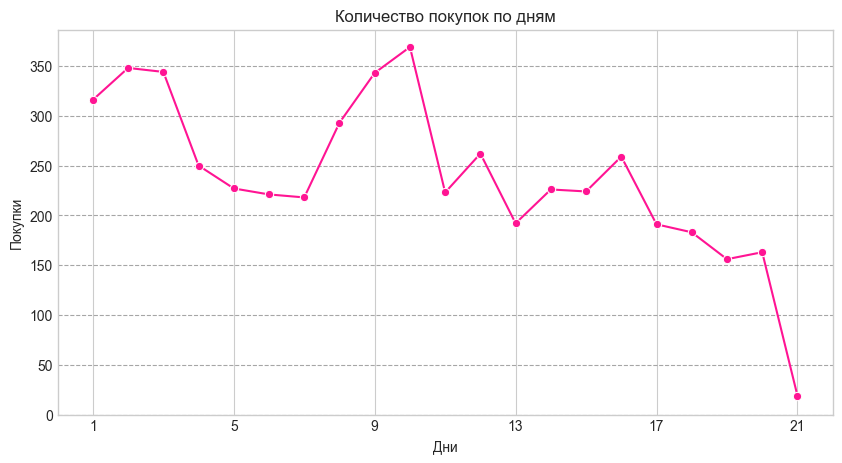

In [22]:
dg = data[data['create_order_flag'] == 1].groupby('day').size().reset_index(name='count')

plt.figure(figsize = (10, 5))

sns.lineplot(data = dg, x = 'day', y = 'count', marker = 'o', color = color)
plt.xticks(ticks=range(1, 22, 4))
plt.yticks(ticks=range(0, int(dg['count'].max()) + 1, 50))

plt.title('Количество покупок по дням')
plt.xlabel('Дни')
plt.ylabel('Покупки')

plt.grid(axis='y', linestyle='--', color='grey', alpha=0.7)
plt.show()

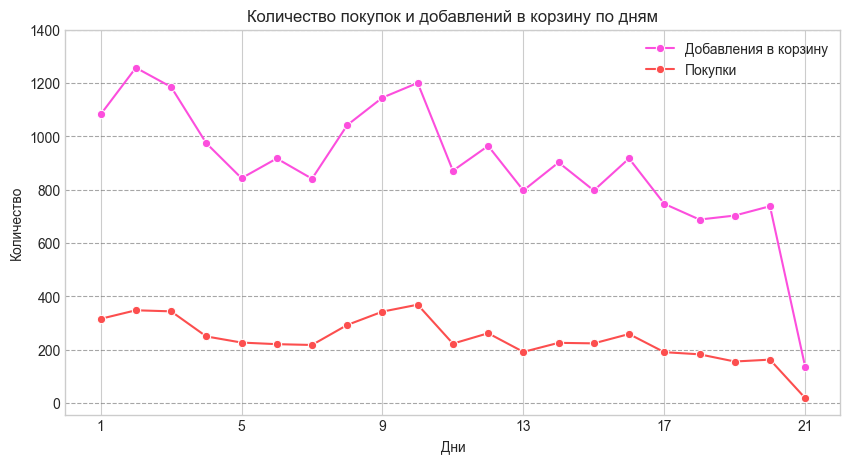

In [23]:
plt.figure(figsize = (10, 5))

dg1 = data[data['add_to_cart_flag'] == 1].groupby('day').size().reset_index(name='count')
dg2 = data[data['create_order_flag'] == 1].groupby('day').size().reset_index(name='count')

sns.lineplot(data = dg1, x = 'day', y = 'count', marker = 'o', color = '#fc4edd', label = 'Добавления в корзину')
sns.lineplot(data = dg2, x = 'day', y = 'count', marker = 'o', color = '#fc4e4e', label = 'Покупки')

plt.xticks(ticks=range(1, 22, 4))
plt.yticks(ticks=range(0, int(dg1['count'].max()) + 200, 200))

plt.title('Количество покупок и добавлений в корзину по дням')
plt.xlabel('Дни')
plt.ylabel('Количество')

plt.grid(axis='y', linestyle='--', color='grey', alpha=0.7)
plt.show()

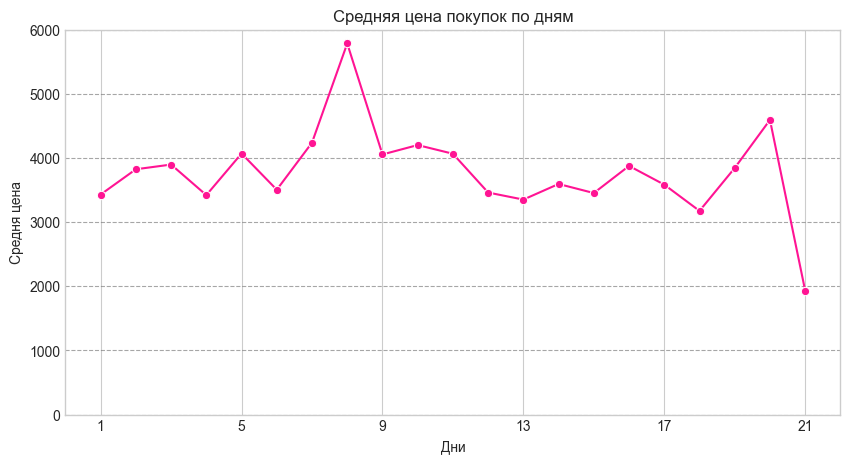

In [24]:
dg = data[data['create_order_flag'] == 1].groupby('day')['product_price'].mean().reset_index()

plt.figure(figsize = (10, 5))

sns.lineplot(data = dg, x = 'day', y = 'product_price', marker = 'o', color = color)
plt.xticks(ticks=range(1, 22, 4))
plt.yticks(ticks=range(0, int(dg['product_price'].max()) + 1000, 1000))

plt.title('Средняя цена покупок по дням')
plt.xlabel('Дни')
plt.ylabel('Средня цена')

plt.grid(axis='y', linestyle='--', color='grey', alpha=0.7)
plt.show()

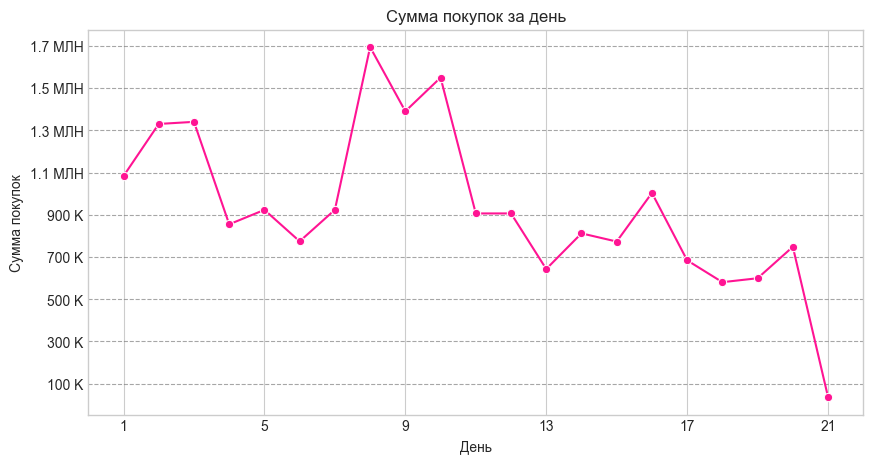

In [25]:
dg = data[data['create_order_flag'] == 1].groupby('day')['product_price'].sum().reset_index()

plt.figure(figsize = (10, 5))

sns.lineplot(data = dg, x = 'day', y = 'product_price', marker = 'o', color = color)
plt.xticks(ticks=range(1, 22, 4))

def format_y_labels(y):
    if y >= 1_000_000:
        return f"{y/1_000_000:.1f} МЛН"
    else:
        return f"{int(y/1000)} K"
        
yticks = range(100_000, int(dg['product_price'].max() + 200_00), 200_000)
plt.yticks(ticks = yticks, labels=[format_y_labels(y) for y in yticks])

plt.title('Сумма покупок за день')
plt.xlabel('День')
plt.ylabel('Сумма покупок')

plt.grid(axis='y', linestyle='--', color='grey', alpha=0.7)
plt.show()

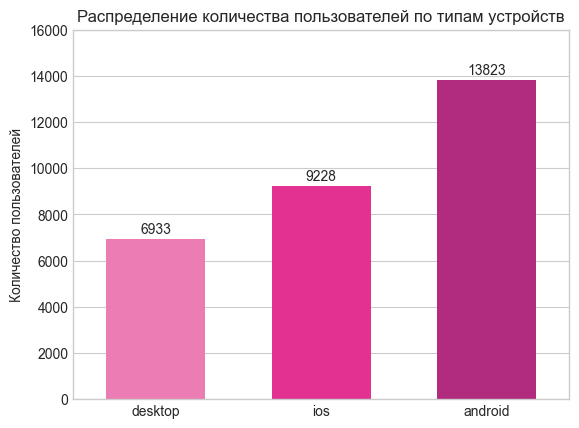

In [26]:
dg = data.drop_duplicates('user_id').groupby('device_type')['user_id'].count().reset_index()
dg.columns = ['device_type', 'count']
dg = dg.sort_values(by = 'count', ascending =True).reset_index(drop = 'True')

ax = sns.barplot(data=dg, x='device_type', y='count', orient='v', hue='device_type', palette=colors, width=0.6)
plt.yticks(ticks=range(0, dg['count'].max() + 4000, 2000))

#универсальная херня для подписей данных
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=2)

plt.title('Распределение количества пользователей по типам устройств')
plt.ylabel('Количество пользователей')
plt.xlabel('')

plt.show()

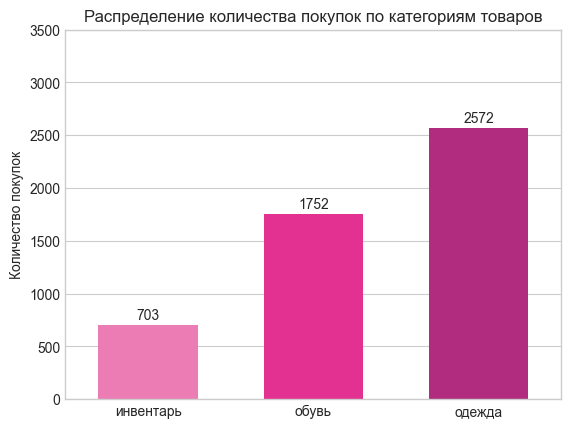

In [27]:
dg = data[data['create_order_flag'] == 1].groupby('product_category')['create_order_flag'].count().reset_index()
dg.columns = ['product_category', 'count']
dg = dg.sort_values(by = 'count', ascending =True).reset_index(drop = 'True')

ax = sns.barplot(data=dg, x='product_category', y='count', orient='v', hue='product_category', palette=colors, width=0.6)
plt.yticks(ticks=range(0, dg['count'].max() + 1000, 500))

#универсальная херня для подписей данных
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=2)

plt.title('Распределение количества покупок по категориям товаров')
plt.ylabel('Количество покупок')
plt.xlabel('')

plt.show()

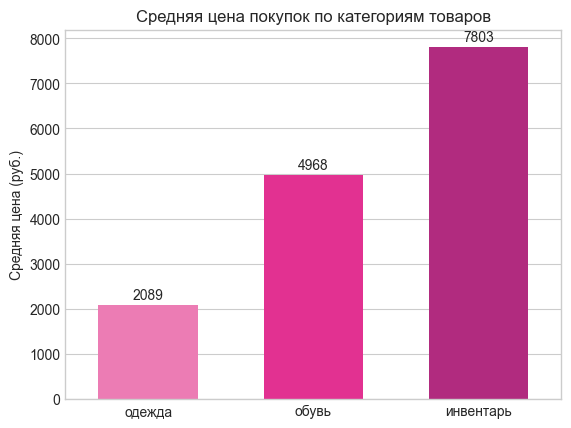

In [28]:
dg = data[data['create_order_flag'] == 1].groupby('product_category')['product_price'].mean().reset_index()
dg.columns = ['product_category', 'mean']
dg = dg.sort_values(by = 'mean', ascending =True).reset_index(drop = 'True')

ax = sns.barplot(data=dg, x='product_category', y='mean', orient='v', hue='product_category', palette=colors, width=0.6)
plt.yticks(ticks=range(0, int(dg['mean'].max() + 1000), 1000))

#универсальная херня для подписей данных
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=2)

plt.title('Средняя цена покупок по категориям товаров')
plt.ylabel('Средняя цена (руб.)')
plt.xlabel('')

plt.show()

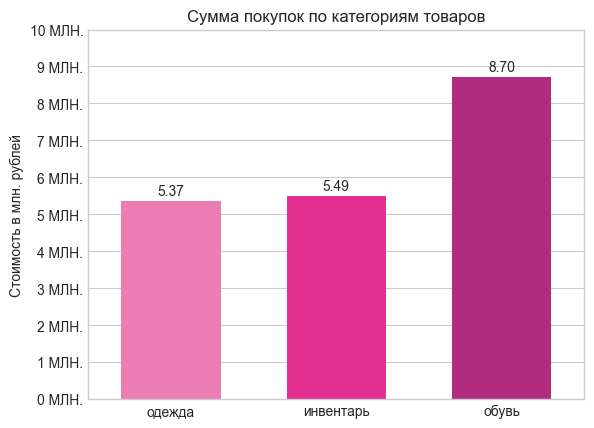

In [29]:
dg = data[data['create_order_flag'] == 1].groupby('product_category')['product_price'].sum().reset_index()
dg.columns = ['product_category', 'sum']
dg['sum'] = dg['sum'] / 1000000
dg = dg.sort_values(by = 'sum', ascending =True).reset_index(drop = 'True')

ax = sns.barplot(data=dg, x='product_category', y='sum', orient='v', hue='product_category', palette=colors, width=0.6)

yticks = range(0, int(dg['sum'].max() + 3), 1)
plt.yticks(ticks=yticks, 
           labels=[f'{y} МЛН.' for y in yticks]
          )

#универсальная херня для подписей данных
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=2)

plt.title('Сумма покупок по категориям товаров')
plt.ylabel('Стоимость в млн. рублей')
plt.xlabel('')

plt.show()

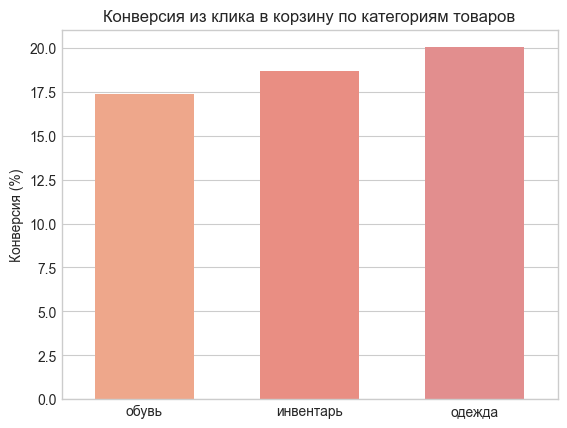

In [30]:
res = []
for d in ['обувь', 'одежда', 'инвентарь']:
    dataf = data.loc[data['product_category'] == d]
    conv = dataf.loc[dataf['add_to_cart_flag'] == 1].shape[0]
    convr = (conv / dataf.shape[0]) * 100

    res.append({
        'cate': d,
        'conversion': convr
    })

dfr = pd.DataFrame(res)
dfr = dfr.sort_values(by='conversion', ascending=True)

ax = sns.barplot(data=dfr, x='cate', y='conversion', orient='v', hue='cate', palette=colors1, width=0.6)

plt.title('Конверсия из клика в корзину по категориям товаров')
plt.ylabel('Конверсия (%)')
plt.xlabel('')

plt.show()

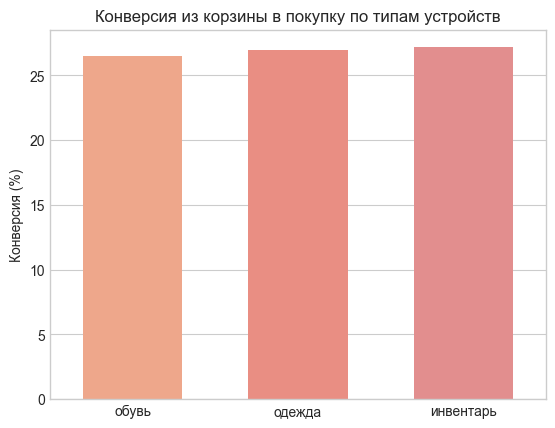

In [31]:
res = []
for d in ['обувь', 'одежда', 'инвентарь']:
    dataf = data.loc[data['product_category'] == d]
    conv1 = dataf.loc[dataf['add_to_cart_flag'] == 1].shape[0]
    conv2 = dataf.loc[dataf['create_order_flag'] == 1].shape[0]
    convr = (conv2 / conv1) * 100

    res.append({
        'cate': d,
        'conversion': convr
    })

dfr = pd.DataFrame(res)
dfr = dfr.sort_values(by='conversion', ascending=True)

ax = sns.barplot(data=dfr, x='cate', y='conversion', orient='v', hue='cate', palette=colors1, width=0.6)

plt.title('Конверсия из корзины в покупку по типам устройств')
plt.ylabel('Конверсия (%)')
plt.xlabel('')

plt.show()

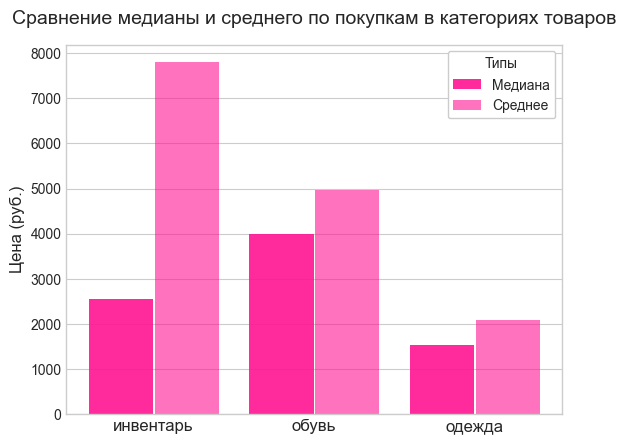

In [32]:
dataf = data.loc[data['create_order_flag'] == 1]
medianp = dataf.groupby('product_category')['product_price'].median()
meanp = dataf.groupby('product_category')['product_price'].mean()

x = range(len(medianp))
plt.bar(x, medianp, align='center', width=0.4, label='Медиана', color=color, alpha=0.9)
plt.bar([p + 0.41 for p in x], meanp, width=0.4, label='Среднее',color=color, alpha=0.6)

plt.title('Сравнение медианы и среднего по покупкам в категориях товаров', fontsize=14, pad=15)
plt.ylabel('Цена (руб.)', fontsize=12)
plt.xticks([p + 0.2 for p in x], medianp.index, fontsize=12)
plt.grid(axis='x')
plt.legend(title='Типы', frameon=True, framealpha=1)
plt.show()

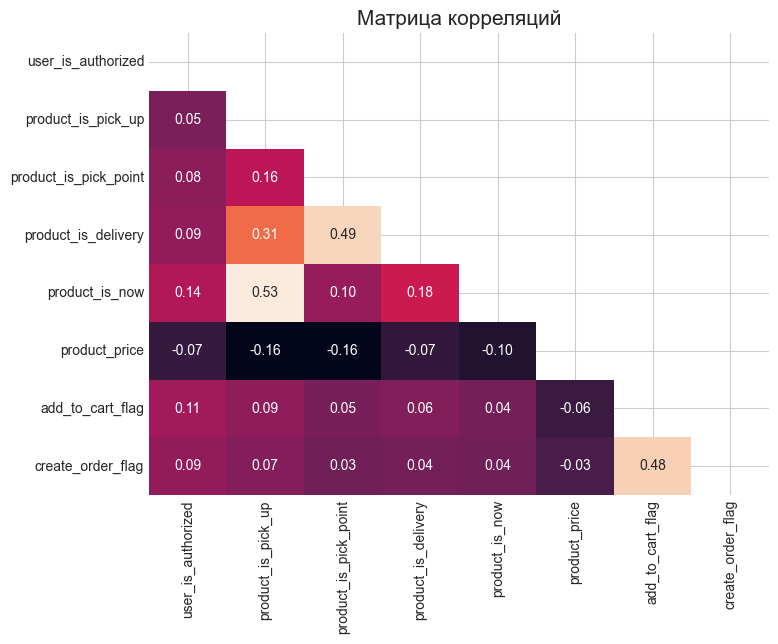

In [33]:
plt.figure(figsize=(8, 6))
cols = data[['user_is_authorized', 'product_is_pick_up', 'product_is_pick_point',
             'product_is_delivery', 'product_is_now', 'product_price',
             'add_to_cart_flag', 'create_order_flag']]
cols = cols.columns.tolist()
corrd = data[cols]
corrm = corrd.corr()

mask = np.triu(np.ones_like(corrm, dtype=bool))

sns.heatmap(corrm, annot=True, fmt='.2f', mask=mask, cbar=False, cmap="rocket")

plt.title('Матрица корреляций', fontsize=15)
plt.show()

# Математика

In [34]:
# Н0: дисперсии двух групп не отличаются
# Н1: дисперсии двух групп отличаются

# фильтрация и групировка
purchase = data[data['create_order_flag'] > 0]
purchase = purchase.groupby(['product_category', 'user_id', 'product_id']).agg({'product_price': 'mean'}).reset_index()

purchase_inv = purchase[purchase['product_category'] == 'инвентарь']['product_price']
purchase_ost = purchase[purchase['product_category'] != 'инвентарь']['product_price']

# Тест Левене
stat, p_value = levene(purchase_inv, purchase_ost)
print(f"Тест Ливена: p-value = {p_value}")

print(f"Дисперсия инвентаря: {np.var(purchase_inv, ddof=1):.3f}")
print(f"Дисперсия остального: {np.var(purchase_ost, ddof=1):.3f}")
# p-value < 0.05 → Отвергаем Н0. Итог: Дисперсии двух груп отличаются

Тест Ливена: p-value = 1.4267411833505568e-47
Дисперсия инвентаря: 159858240.290
Дисперсия остального: 11834146.211


In [35]:
#Односторонний двухвыборочный Т-тест Уэльча для разных дисперсий, который проверяет что среднее инвернтаря БОЛЬШЕ чем среднее других.
t_stat, p_value = ttest_ind(purchase_inv, purchase_ost, alternative='greater', equal_var=False)

print(f"Разница средних: {purchase_inv.mean() - purchase_ost.mean()}")
print(f"t-статистика: {t_stat}, p-значение: {p_value}")
# P-value > 0.05, значит отвергаем Н0. Итог: Средняя цена инвентаря > средней цены остальных товаров

Разница средних: 3303.6976693688475
t-статистика: 6.25408894313607, p-значение: 3.8259039200234846e-10


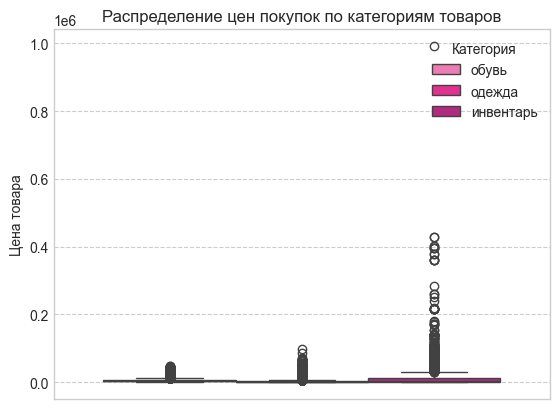

In [36]:
sns.boxplot(data=data, y='product_price', hue='product_category', palette=colors)

plt.legend(title='Категория', loc='upper right')

plt.title('Распределение цен покупок по категориям товаров')
plt.ylabel('Цена товара')
plt.grid(axis='y', linestyle='--')

In [37]:
purc = data.loc[data['create_order_flag'] == 1]

Q1 = purc['product_price'].quantile(0.25)  # 25-й процентиль
Q3 = purc['product_price'].quantile(0.75)  # 75-й процентиль
IQR = Q3 - Q1                     # Межквартильный размах

upper_bound = Q3 + 1.5 * IQR       # Верхняя граница
lower_bound = Q1 - 1.5 * IQR       # Нижняя граница (если нужно)

# Фильтруем данные, удаляя выбросы
filtered_data = purc[(purc['product_price'] <= upper_bound)]

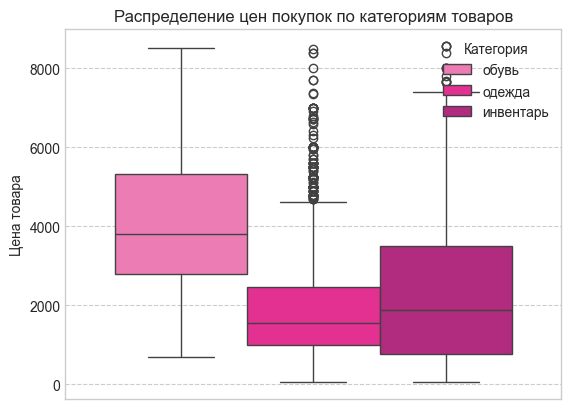

In [38]:
sns.boxplot(data=filtered_data, y='product_price', hue='product_category', palette=colors)

plt.legend(title='Категория', loc='upper right')

plt.title('Распределение цен покупок по категориям товаров')
plt.ylabel('Цена товара')
plt.grid(axis='y', linestyle='--')

In [39]:
clean = pd.DataFrame()
for i in ['обувь', 'одежда', 'инвентарь']:
    dataf = data[(data['product_category'] == i) & (data['create_order_flag'] == 1)]
    Q1 = dataf['product_price'].quantile(0.25)  # 25-й процентиль
    Q3 = dataf['product_price'].quantile(0.75)  # 75-й процентиль
    IQR = Q3 - Q1                     # Межквартильный размах
    
    upper_bound = Q3 + 1.5 * IQR       # Верхняя граница
    lower_bound = Q1 - 1.5 * IQR       # Нижняя граница (если нужно)
    print(f'{i}: {upper_bound}')
    
    filtered_data = dataf[(dataf['product_price'] <= upper_bound)]

    clean = pd.concat([clean, filtered_data], ignore_index=True)

обувь: 10724.0
одежда: 4749.0
инвентарь: 17949.0


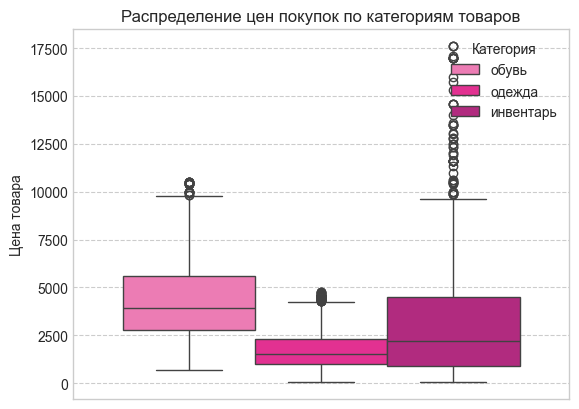

In [40]:
sns.boxplot(data=clean, y='product_price', hue='product_category', palette=colors)

plt.legend(title='Категория', loc='upper right')

plt.title('Распределение цен покупок по категориям товаров')
plt.ylabel('Цена товара')
plt.grid(axis='y', linestyle='--')

In [41]:
purchase_inv1 = clean[clean['product_category'] == 'инвентарь']['product_price']
purchase_ost1 = clean[clean['product_category'] != 'инвентарь']['product_price']
#Односторонний двухвыборочный Т-тест Уэльча для разных дисперсий, который проверяет что среднее инвернтаря БОЛЬШЕ чем среднее других.
t_stat, p_value = ttest_ind(purchase_inv1, purchase_ost1, alternative='greater', equal_var=False)

print(f"Разница средних: {purchase_inv1.mean() - purchase_ost1.mean()}")
print(f"t-статистика: {t_stat}, p-значение: {p_value}")
# P-value > 0.05, значит отвергаем Н0. Итог: Средняя цена инвентаря > средней цены остальных товаров

Разница средних: 870.114950447653
t-статистика: 5.453667441040863, p-значение: 3.503271942644296e-08


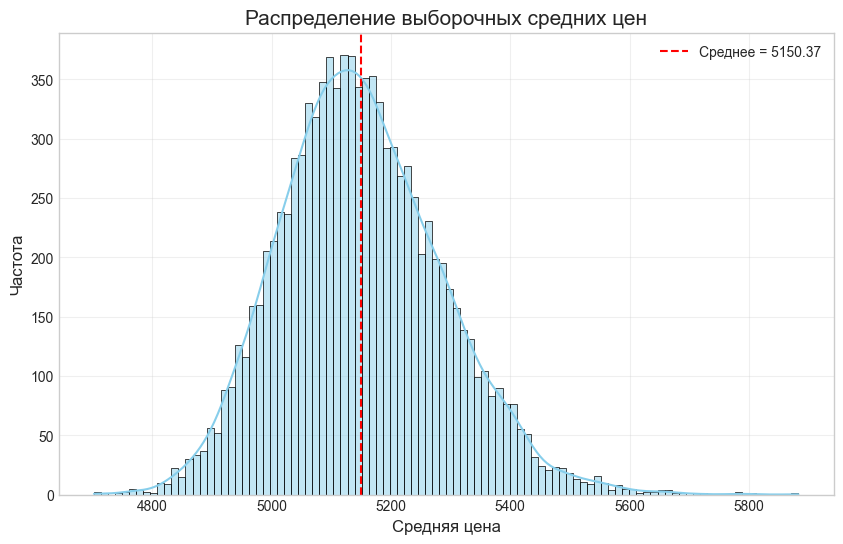

Среднее ГС: 5150.70


In [42]:
#Подтверждение ЦПТ
means = []
for i in range(10_000):
    nd = data['product_price'].sample(5000, replace=True)
    mnd = nd.mean()
    means.append(mnd)
    
plt.figure(figsize=(10, 6))
sns.histplot(means, color='skyblue', bins=100, kde=True)
plt.title('Распределение выборочных средних цен', fontsize=15)
plt.xlabel('Средняя цена', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True, alpha=0.3)

mean_price = np.mean(means)
plt.axvline(mean_price, color='red', linestyle='--', label=f'Среднее = {mean_price:.2f}')
plt.legend()

plt.show()
print(f"Среднее ГС: {data['product_price'].mean():.2f}")